<a href="https://colab.research.google.com/github/ali77sina/Novelty_detection_encoder/blob/main/synthetic_enc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [85]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from sklearn.utils import shuffle

In [197]:
#defining training set length and parameters
pi = np.pi  #value of pi
n = 5000  #number of training sets
sec = 3 #length of the sin wave
amp_mu = 2  #mean of the amplitude dist
amp_sig = 0.1 #std of the amplitude dist
amp_mu_ab = 30  #mean of the abnormal amplitude dist
amp_sig_ab = 0.1 #std of the abnormal amplitude dist
f_max = 5 #maximum frequency recorded in Hz
fs = 512  #samplig frequency in Hz

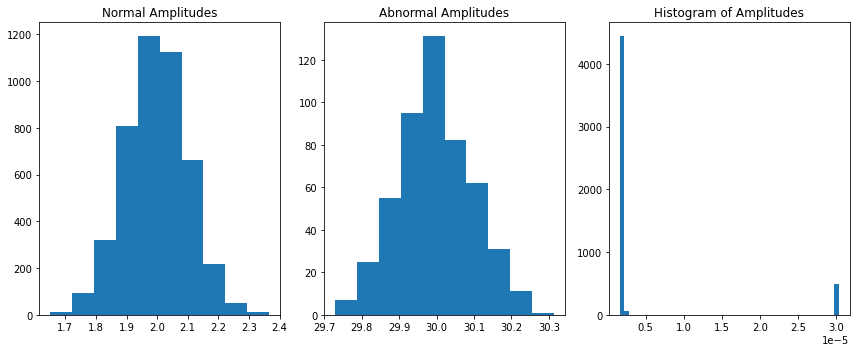

In [113]:
#Gaussian distribution of amplitudes 
plt.rcParams["figure.figsize"] = (12,5)
r = 0.1
num_norm = int(n*(1-r))
num_ab = int(n*r)
amps_norm = np.random.normal(amp_mu,amp_sig,num_norm)
amps_ab = np.random.normal(amp_mu_ab,amp_sig_ab,num_ab)
amps = np.concatenate((amps_norm, amps_ab), axis = 0)
#shuffling the amplitudes vector for training
amps = shuffle(amps)
#converting units to uV
amps = amps*10**-6
#plotting
plt.subplot(131)
plt.hist(amps_norm)
plt.title('Normal Amplitudes')
plt.subplot(132)
plt.hist(amps_ab)
plt.title('Abnormal Amplitudes')
plt.subplot(133)
plt.hist(amps, bins = 50)
plt.title('Histogram of Amplitudes')
plt.tight_layout()

Text(0.5, 0, 'Frequency (Hz)')

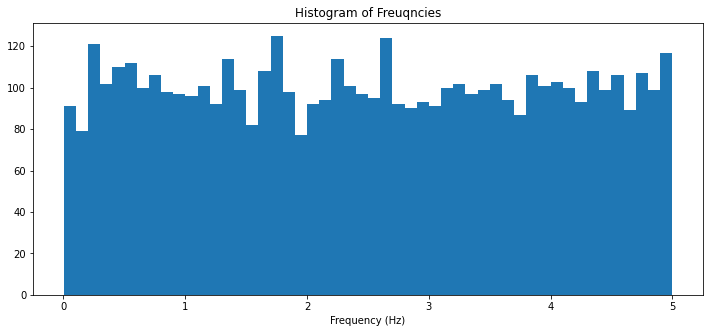

In [198]:
#uniformly distributed frequencies
f = np.random.random(n)*f_max
plt.hist(f, bins = 50)
plt.title('Histogram of Freuqncies')
plt.xlabel('Frequency (Hz)')

In [115]:
#making the synthetic training set
t = np.linspace(0,sec,fs*sec) #defining the time vector
x_train = np.zeros(shape = (n, fs*sec)) + (np.random.random(fs*sec) - 0.5)*0.1
for i in range(n):
  x_train[i] = amps[i]*np.sin(2*pi*f[i]*t)
print(x_train.shape)

(5000, 1536)


In [116]:
inp = tf.keras.layers.Input(shape=(fs*sec)) #input recieveing the sin waves
hid = tf.keras.layers.Dense(128, activation = 'relu')(inp)  #one hidden layer 
latent = tf.keras.layers.Dense(2, activation = 'sigmoid')(hid) #latent space
model_m = tf.keras.models.Model(inputs = inp, outputs = latent) 
model_m.compile(optimizer = 'adam', metrics = ['accuracy'], loss = 'binary_crossentropy') #model compiled to map input into the latent space later
hid = tf.keras.layers.Dense(128, activation = 'relu')(model_m.output) #hidden layer in decoding network
out = tf.keras.layers.Dense(fs*sec)(hid)  #output reconstructing the sin vector (decoding)
model_f = tf.keras.models.Model(inputs = inp, outputs = out)
model_f.compile(optimizer = 'adam', metrics = ['accuracy'], loss = 'mse')

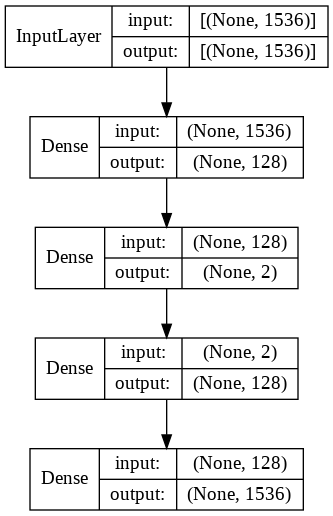

In [204]:
tf.keras.utils.plot_model(model_f, show_shapes=True, show_layer_names=False)

In [117]:
for i in range(5000):
  ind1 = int(np.random.random()*len(x_train))
  ind2 = ind1 + 125
  loss, _ = model_f.train_on_batch(x_train[ind1:ind2], x_train[ind1:ind2])
  if i%500 == 0:
    print(i)
    print(loss)
    print('\n')

0
0.0005735406884923577


500
4.0950215440815896e-11


1000
4.187065971716919e-11


1500
4.789159346874072e-11


2000
5.6347940202705615e-11


2500
3.8505636179575475e-11


3000
5.283477128026348e-11


3500
5.042670447874542e-11


4000
1.8150432545827044e-11


4500
4.712212564594864e-11


5000
5.017232115878123e-11


5500
6.766352755871452e-11


6000
3.257478661811142e-11


6500
5.39218392159313e-11




KeyboardInterrupt: ignored

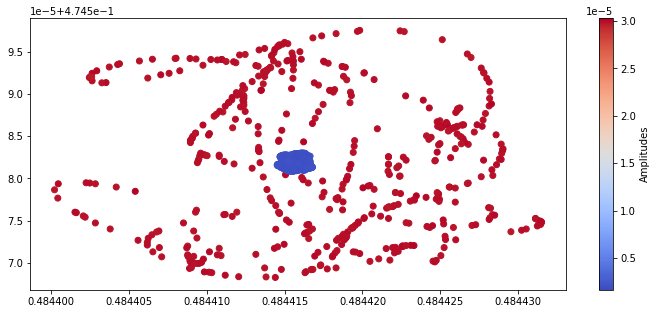

In [208]:
#latent space representation
preds = model_m.predict(x_train)
plt.scatter(preds[:,0], preds[:,1], c = amps, cmap = 'coolwarm')
plt.colorbar(label = 'Amplitudes')

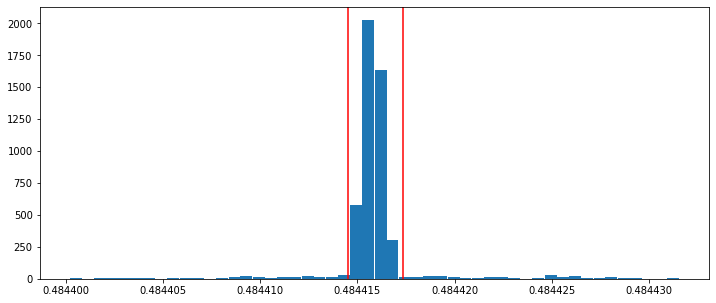

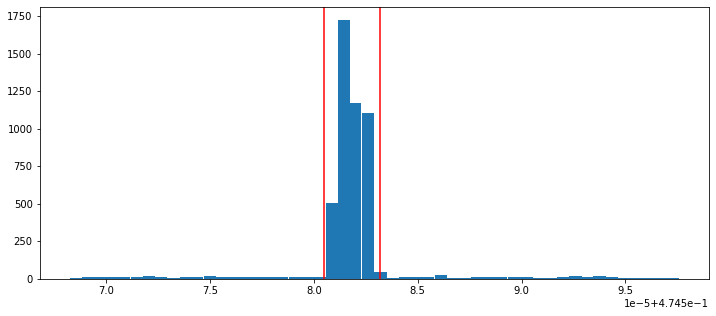

In [211]:
plt.hist(preds[:,0], bins = 50)
mu0 = np.mean(preds[:,0])
sig0 = np.std(preds[:,0])
m0 = 0.6
#vertical lines denoting thresholds
plt.axvline(mu0 + m0*sig0, color = 'red')
plt.axvline(mu0 - m0*sig0, color = 'red')
plt.show()
mu1 = np.mean(preds[:,1])
sig1 = np.std(preds[:,1])
m1 = 0.5
#vertical lines denoting thresholds
plt.axvline(mu1 + m1*sig1, color = 'red')
plt.axvline(mu1 - m1*sig1, color = 'red')
plt.hist(preds[:,1], bins = 50)
plt.show()

In [187]:
#collecting outlier indecies based on thresholds
num1 = [i for i,j in enumerate(preds[:,0]) if j < mu0 - m0*sig0 or j > mu0 + m0*sig0]
num2 = [i for i,j in enumerate(preds[:,1]) if j < mu1 - m1*sig1 or j > mu1 + m1*sig1]
num = np.concatenate((num1, num2), axis = 0)

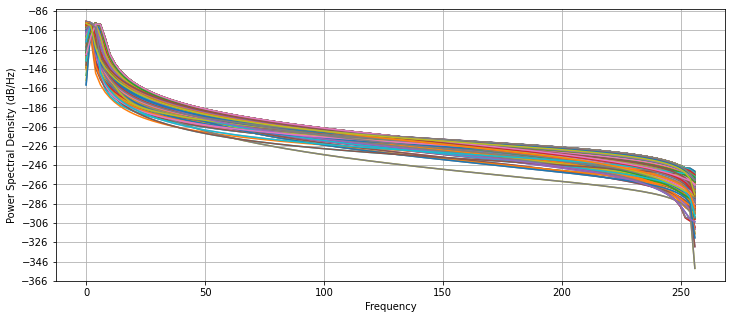

In [189]:
#PSD for abnormal samples
vals_ab = []
for i in num:
  temp, freq = plt.psd(x_train[int(i)], Fs = fs)
  vals_ab.append(temp)

In [190]:
#Averaging PSD values 
vals_ab = np.array(vals_ab)
print(vals_ab.shape)
means_abnormal = np.zeros(129)
stds_abnormal = np.zeros(129)
for i in range(129):
  means_abnormal[i] = np.mean(np.log(vals_ab[:,i]))
  stds_abnormal[i] = np.std(np.log(vals_ab[:,i]))

(899, 129)


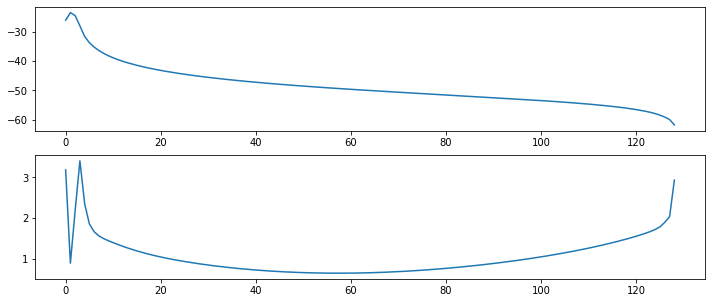

In [191]:
plt.plot(means_abnormal)

In [192]:
#indecies for normal snippets 
normal = []
for i in range(len(num)):
  ind = np.random.random()*len(x_train)
  ind = int(ind)
  isin = False
  for j in num:
    if j == ind:
      isin = True
  if not isin:
    normal.append(x_train[ind])

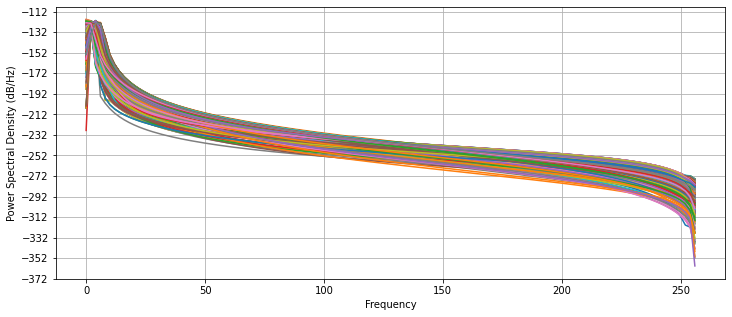

In [193]:
new_vals = []
for i in normal:
  temp, freq = plt.psd(i, Fs = fs)
  new_vals.append(temp)

In [194]:
new_vals = np.array(new_vals)
print(new_vals.shape)
means_normal = np.zeros(129)
stds_normal = np.zeros(129)
for i in range(129):
  means_normal[i] = np.mean(np.log(new_vals[:,i]))
  stds_normal[i] = np.std(np.log(new_vals[:,i]))

(808, 129)


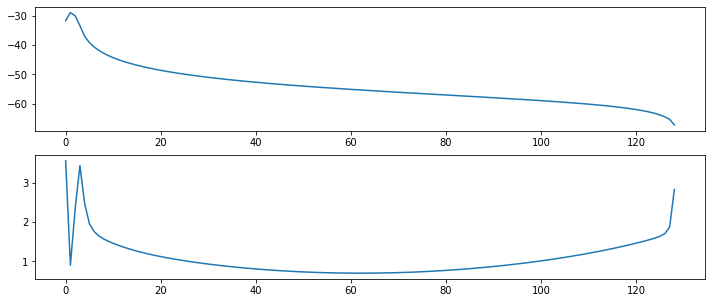

In [195]:
plt.plot(means_normal)

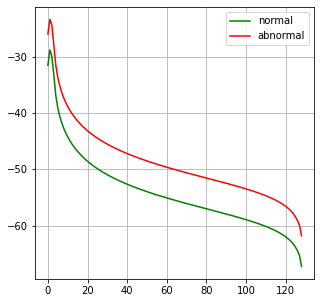

In [215]:
plt.rcParams["figure.figsize"] = (5,5)

plt.plot(means_normal, color = 'green', label = 'normal')
plt.plot(means_abnormal, color = 'red', label = 'abnormal')
plt.grid()
plt.legend()